In [1]:
!pip install pandas-profiling -q 
!pip install scikit-learn==1.1.3 -q 
!pip install catboost -q 
!pip install lightgbm -q 

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Описание данных:

* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

## Подготовка данных

In [2]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp
import re
import time

from math import sqrt
from tqdm import tqdm
from scipy.stats import uniform, randint
from ydata_profiling import ProfileReport

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer   
from sklearn.metrics import(
    mean_squared_error,
    make_scorer
)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.preprocessing import(
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)

import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

STATE = 5

In [3]:
# autos = pd.read_csv('/datasets/autos.csv')

In [4]:
autos = pd.read_csv('C:/Users/nedel/Desktop/Projects/autos.csv')

In [5]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
#ProfileReport(autos)

Наш датасет содержит 354369 строк и 16 столбцов. Некоторые признаки содержат пропущенные значения, такие как "VehicleType", "Gearbox", "Model", "FuelType" и "Repaired". Все признаки, кроме "Price", "Power" и "PostalCode", имеют тип данных "object", поэтому нам нужно будет преобразовать некоторые из них в числовой формат.

Также, стоит обратить внимание на столбцы, связанные с датами: "DateCrawled", "DateCreated" и "LastSeen". Они также имеют тип данных "object" и нуждаются в обработке. Для начала, мы можем преобразовать их в формат даты и времени, чтобы потом использовать их для извлечения других признаков.

Заметна высокая корреляция между `price` и `registration_year`, а так же `price` и `power`. У `registration_year` высокая корреляция с `vehicle_type` 


Приведем столбцы к snake_case

In [7]:
snake_case_names = []
for name in autos.columns:
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name) # приводим к camelCase
    s2 = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower() # приводим к snake_case
    snake_case_names.append(s2)

print(snake_case_names)

['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen']


In [8]:
autos.columns = snake_case_names

In [9]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [10]:
autos.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

В первую очередь избавимся от пропусков которые присутвуют во всех столбцах

In [11]:
remove = autos.loc[
    (autos['vehicle_type'].isna()) &
    (autos['gearbox'].isna()) &
    (autos['model'].isna()) &
    (autos['fuel_type'].isna()) &
    (autos['repaired'].isna())
]

print(f'Доля строк с пропусками во всех столбцах: {len(remove)/len(autos):.2%}')
autos = autos.drop(remove.index)

Доля строк с пропусками во всех столбцах: 0.63%


In [12]:
autos.isna().sum()

date_crawled              0
price                     0
vehicle_type          35253
registration_year         0
gearbox               17596
power                     0
model                 17468
kilometer                 0
registration_month        0
fuel_type             30658
brand                     0
repaired              68917
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [13]:
autos['model'] = autos.groupby('brand')['model'].transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
autos['model'].isna().sum()

2677

In [14]:
autos = autos.dropna(subset=['model']) 
autos['model'].isna().sum()

0

In [15]:
autos['vehicle_type'] = (
    autos
    .groupby(['brand', 'model'])['vehicle_type']
    .transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
)

autos['vehicle_type'].isna().sum()

0

In [16]:
autos['gearbox'] = (
    autos
    .groupby(['brand', 'model'])['gearbox']
    .transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
)
autos['gearbox'].isna().sum()

0

In [17]:
autos['fuel_type'] = (
    autos
    .groupby(['brand', 'model'])['fuel_type']
    .transform(lambda x: x.fillna(x.mode()[0]) if not x.mode().empty else x)
)
autos['fuel_type'].isna().sum()

0

In [18]:
autos['repaired'] = autos['repaired'].fillna(autos['repaired'].mode()[0])
autos['repaired'].isna().sum()

0

Изменим формат дат на datetime

In [19]:
autos['date_crawled'] = pd.to_datetime(autos['date_crawled'], format='%Y-%m-%d %H:%M:%S')
autos['date_created'] = pd.to_datetime(autos['date_created'], format='%Y-%m-%d %H:%M:%S')
autos['last_seen'] = pd.to_datetime(autos['last_seen'], format='%Y-%m-%d %H:%M:%S')

<AxesSubplot:>

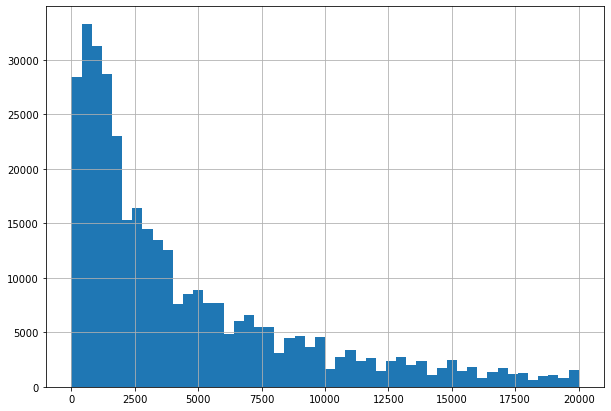

In [20]:
autos['price'].hist(bins=50, figsize=(10,7))

Избавимся от слишком маленьких значений в столбце price

In [21]:
autos = autos.loc[autos['price'] > 200]

<AxesSubplot:>

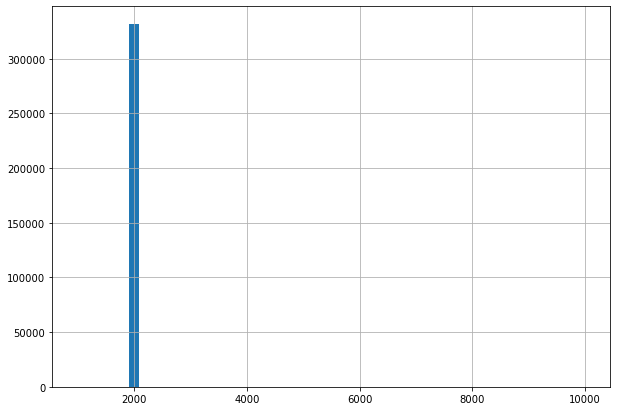

In [22]:
autos['registration_year'].hist(bins=50, figsize=(10,7))

In [23]:
print('Последняя дата скачивания анкеты из базы:', autos['date_crawled'].max())

Последняя дата скачивания анкеты из базы: 2016-04-07 14:36:58


Избавимся от аномалий в толбце registration_year, удалив 5 и 95 процентили.

In [24]:
autos = (autos[(autos['registration_year'] >= 1992) & (autos['registration_year'] <= 2016)])

<AxesSubplot:>

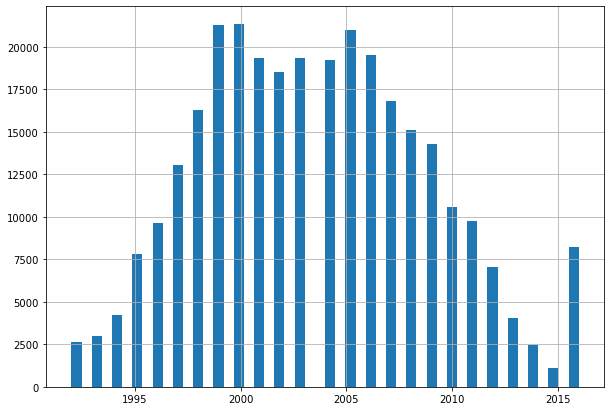

In [25]:
autos['registration_year'].hist(bins=50, figsize=(10,7))

In [26]:
print(np.sort(autos['power'].unique()))

[    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    22    23    24
    25    26    29    30    31    33    34    35    36    37    38    39
    40    41    42    43    44    45    46    47    48    49    50    51
    52    53    54    55    56    57    58    59    60    61    62    63
    64    65    66    67    68    69    70    71    72    73    74    75
    76    77    78    79    80    81    82    83    84    85    86    87
    88    89    90    91    92    93    94    95    96    97    98    99
   100   101   102   103   104   105   106   107   108   109   110   111
   112   113   114   115   116   117   118   119   120   121   122   123
   124   125   126   127   128   129   130   131   132   133   134   135
   136   137   138   139   140   141   142   143   144   145   146   147
   148   149   150   151   152   153   154   155   156   157   158   159
   160   161   162   163   164   165   166   167   

(0.0, 1000.0)

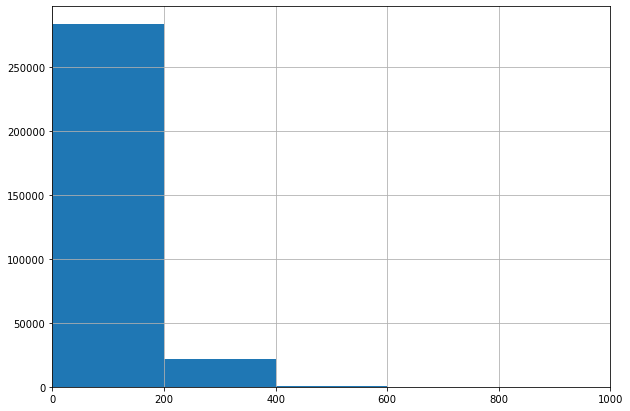

In [27]:
autos['power'].hist(bins=100, figsize=(10,7))
plt.xlim(0, 1000)

Удалим 0 значения и значения больше 400 л.с

In [28]:
autos['power'] = (
    autos
    .groupby('brand')['power']
    .apply(lambda x: x.replace(0, x.median()))
)
autos = autos.loc[(autos['power'] >= 50) & (autos['power'] <= 400)]

<AxesSubplot:>

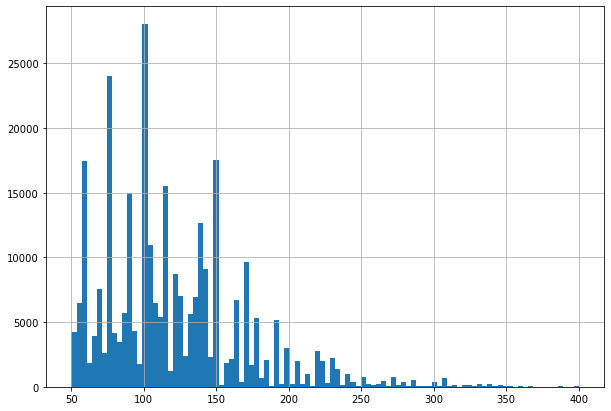

In [29]:
autos['power'].hist(bins=100, figsize=(10,7))

Заменим gasoline на petrol т.к. это одно и тоже (бензин)

In [30]:
autos['fuel_type'] = autos['fuel_type'].replace('gasoline', 'petrol')

In [31]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301581 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        301581 non-null  datetime64[ns]
 1   price               301581 non-null  int64         
 2   vehicle_type        301581 non-null  object        
 3   registration_year   301581 non-null  int64         
 4   gearbox             301581 non-null  object        
 5   power               301581 non-null  float64       
 6   model               301581 non-null  object        
 7   kilometer           301581 non-null  int64         
 8   registration_month  301581 non-null  int64         
 9   fuel_type           301581 non-null  object        
 10  brand               301581 non-null  object        
 11  repaired            301581 non-null  object        
 12  date_created        301581 non-null  datetime64[ns]
 13  number_of_pictures  301581 no

Для предсказания цены автомобиля полезными могут быть следующие столбцы:

* Price: целевая переменная, которую мы хотим предсказать.
* Model: модель автомобиля может оказать влияние на цену.
* RegistrationYear: год регистрации автомобиля может оказать влияние на цену.
* Power: мощность автомобиля тоже может повлиять на цену.
* Kilometer: пробег может также влиять на цену, чем больше пробег, тем меньше цена.
* VehicleType: тип кузова может оказать влияние на цену автомобиля.
* Gearbox: тип коробки передач также может повлиять на цену.
* FuelType: тип топлива может оказать влияние на цену автомобиля.
* Brand: бренд автомобиля может оказать сильное влияние на цену.
* Repaired: информация о том, был ли автомобиль в ремонте, может оказать влияние на цену.


In [32]:
filtered_autos = autos[['price', 
                        'model', 
                        'registration_year',
                        'power',
                        'kilometer',
                        'vehicle_type',
                        'gearbox',
                        'fuel_type',
                        'brand',
                        'repaired']]
filtered_autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301581 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              301581 non-null  int64  
 1   model              301581 non-null  object 
 2   registration_year  301581 non-null  int64  
 3   power              301581 non-null  float64
 4   kilometer          301581 non-null  int64  
 5   vehicle_type       301581 non-null  object 
 6   gearbox            301581 non-null  object 
 7   fuel_type          301581 non-null  object 
 8   brand              301581 non-null  object 
 9   repaired           301581 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 25.3+ MB


Удалим явные дубликаты

In [33]:
filtered_autos = filtered_autos.drop_duplicates().reset_index(drop=True)

In [34]:
#ProfileReport(filtered_autos)

Вывод:

Подготовили данные к обучению, избавились от аномалий, привлеи столбцы к snake_case оставили только нужные для обучения столбцы

## Обучение моделей

Выберем следующие модели обучения:

* `LinearRegression`
* `RandomForestRegressor`
* `CatBoostRegressor`
* `LGBMRegressor`

Подготовим `три` типа признаков:

* Исходные.
* Закодированные (Т.к столбец `'model'` и `brand` имеют `247` и `39` уникальних значений их мы закодируем методом `OrdinalEncoder`, а остальные категориальные признаки мы закодируем с помощью `OneHotEncoder` ):
    * С примением `StandardScaler()`
    * Без `StandardScaler()`
    

In [35]:
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

In [36]:
# Функция расчета rmse
def rmse(actual, pred):
    return mean_squared_error(actual, pred, squared=False)

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [37]:
features = filtered_autos.drop(['price'], axis=1)
target = filtered_autos['price']

In [38]:
# разделяем выборку на обучающую и тестовую
X_train_orig, X_test_orig, y_train, y_test = train_test_split(
    features, 
    target, 
    test_size=0.25, 
    random_state=STATE
)

In [39]:
scaler = StandardScaler()

In [40]:
cat_features = X_train_orig.select_dtypes(include='object').columns.to_list()
cat_features.remove('model')
cat_features.remove('brand')
num_features = ['registration_year', 'power', 'kilometer', 'model', 'brand']
print(cat_features)
print(num_features)

['vehicle_type', 'gearbox', 'fuel_type', 'repaired']
['registration_year', 'power', 'kilometer', 'model', 'brand']


In [41]:
# применяем OrdinalEncoder для столбца 'model'
oe = OrdinalEncoder()

X_train_encoded = X_train_orig.copy()
X_test_encoded = X_test_orig.copy()

X_train_oe = oe.fit_transform(X_train_encoded[['model', 'brand']])
X_train_encoded[['model', 'brand']] = X_train_oe

X_test_oe = oe.transform(X_test_encoded[['model', 'brand']])
X_test_encoded[['model', 'brand']] = X_test_oe

In [42]:
# применяем OneHotEncoder 

ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
ohe.fit(X_train_encoded[cat_features])

X_train_encoded[
    ohe.get_feature_names_out()
] = ohe.transform(X_train_encoded[cat_features])

X_train_encoded = X_train_encoded.drop(cat_features, axis=1)

In [43]:
X_test_encoded[
    ohe.get_feature_names_out()
] = ohe.transform(X_test_encoded[cat_features])

X_test_encoded = X_test_encoded.drop(cat_features, axis=1)

In [44]:
# применяем StandardScaler
scaler = StandardScaler()

X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

X_train_scaled[num_features] = scaler.fit_transform(X_train_scaled[num_features])
X_test_scaled[num_features] = scaler.transform(X_test_scaled[num_features])

In [45]:
get_data_info(X_train_orig)

,model,registration_year,power,kilometer,vehicle_type,gearbox,fuel_type,brand,repaired
53907,a_klasse,2006,82.0,150000,sedan,manual,petrol,mercedes_benz,no
33004,scenic,2002,102.0,150000,bus,manual,petrol,renault,no
179430,a4,1997,125.0,150000,wagon,manual,petrol,audi,no
162513,a6,1995,174.0,150000,wagon,auto,petrol,audi,yes
87086,bora,1998,101.0,150000,sedan,manual,petrol,volkswagen,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 185524 entries, 188786 to 35683
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   model              185524 non-null  object 
 1   registration_year  185524 non-null  int64  
 2   power              185524 non-null  float64
 3   kilometer          185524 non-null  int64  
 4   vehicle_type       185524 non-null  object 
 5   gearbox            185524 non-null  object 
 6   fuel_type          185524 non-null  object 
 7   brand              185524 non-null  object 
 8   repaired           185524 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 14.2+ MB


None

,model,registration_year,power,kilometer,vehicle_type,gearbox,fuel_type,brand,repaired
count,185524,185524.000000,185524.000000,185524.000000,185524,185524,185524,185524,185524
unique,247,NaN,NaN,NaN,8,2,6,39,2
top,golf,NaN,NaN,NaN,sedan,manual,petrol,volkswagen,no
freq,14486,NaN,NaN,NaN,53759,146780,181686,36254,166152
mean,NaN,2003.759821,122.717204,127030.087751,NaN,NaN,NaN,NaN,NaN
std,NaN,5.386362,50.619245,37589.935926,NaN,NaN,NaN,NaN,NaN
min,NaN,1992.000000,50.000000,5000.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,2000.000000,87.000000,125000.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,2004.000000,114.000000,150000.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,2008.000000,150.000000,150000.000000,NaN,NaN,NaN,NaN,NaN


In [46]:
get_data_info(X_test_encoded)

,model,registration_year,power,kilometer,brand,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,fuel_type_electric,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,repaired_yes
153780,29.0,1997,150.0,150000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
242695,29.0,2005,150.0,150000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
225500,116.0,2007,105.0,150000,37.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
133683,83.0,2011,86.0,70000,24.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
199408,174.0,2002,126.0,150000,23.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 61842 entries, 217602 to 215047
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   model                     61842 non-null  float64
 1   registration_year         61842 non-null  int64  
 2   power                     61842 non-null  float64
 3   kilometer                 61842 non-null  int64  
 4   brand                     61842 non-null  float64
 5   vehicle_type_convertible  61842 non-null  float64
 6   vehicle_type_coupe        61842 non-null  float64
 7   vehicle_type_other        61842 non-null  float64
 8   vehicle_type_sedan        61842 non-null  float64
 9   vehicle_type_small        61842 non-null  float64
 10  vehicle_type_suv          61842 non-null  float64
 11  vehicle_type_wagon        61842 non-null  float64
 12  gearbox_manual            61842 non-null  float64
 13  fuel_type_electric        61842 non-null  float64
 14  

None

,model,registration_year,power,kilometer,brand,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,fuel_type_electric,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,repaired_yes
count,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000
mean,106.846367,2003.754083,122.567753,127134.310016,19.924339,0.063468,0.048446,0.009767,0.289092,0.236765,0.039585,0.212170,0.790692,0.000178,0.000744,0.016041,0.000340,0.980838,0.102713
std,70.807271,5.369466,50.380313,37553.612419,12.864561,0.243805,0.214709,0.098344,0.453344,0.425100,0.194983,0.408848,0.406818,0.013336,0.027263,0.125634,0.018425,0.137094,0.303587
min,0.000000,1992.000000,50.000000,5000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.000000,2000.000000,87.000000,125000.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,106.000000,2004.000000,114.000000,150000.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,166.000000,2008.000000,150.000000,150000.000000,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,246.000000,2016.000000,400.000000,150000.000000,38.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
get_data_info(X_test_scaled)

,model,registration_year,power,kilometer,brand,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,fuel_type_electric,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,repaired_yes
205088,-1.192362,-1.997610,0.361184,0.611067,0.699762,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1502,1.115449,-0.141064,-0.132701,0.611067,1.164993,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
232716,-0.597711,-1.069337,-0.448787,0.611067,0.156992,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
68615,0.166840,1.158518,-1.100715,-1.783197,-0.618393,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
176903,-0.059694,-0.326719,-0.646341,0.611067,-0.773470,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 61842 entries, 217602 to 215047
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   model                     61842 non-null  float64
 1   registration_year         61842 non-null  float64
 2   power                     61842 non-null  float64
 3   kilometer                 61842 non-null  float64
 4   brand                     61842 non-null  float64
 5   vehicle_type_convertible  61842 non-null  float64
 6   vehicle_type_coupe        61842 non-null  float64
 7   vehicle_type_other        61842 non-null  float64
 8   vehicle_type_sedan        61842 non-null  float64
 9   vehicle_type_small        61842 non-null  float64
 10  vehicle_type_suv          61842 non-null  float64
 11  vehicle_type_wagon        61842 non-null  float64
 12  gearbox_manual            61842 non-null  float64
 13  fuel_type_electric        61842 non-null  float64
 14  

None

,model,registration_year,power,kilometer,brand,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,gearbox_manual,fuel_type_electric,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,repaired_yes
count,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000,61842.000000
mean,-0.005236,-0.001065,-0.002952,0.002773,-0.003951,0.063468,0.048446,0.009767,0.289092,0.236765,0.039585,0.212170,0.790692,0.000178,0.000744,0.016041,0.000340,0.980838,0.102713
std,1.002514,0.996866,0.995283,0.999036,0.997499,0.243805,0.214709,0.098344,0.453344,0.425100,0.194983,0.408848,0.406818,0.013336,0.027263,0.125634,0.018425,0.137094,0.303587
min,-1.518004,-2.183265,-1.436556,-3.246359,-1.548855,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.979987,-0.698028,-0.705607,-0.054006,-0.851008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,-0.017219,0.044590,-0.172212,0.611067,0.156992,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.832282,0.787209,0.538982,0.611067,0.854839,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.964950,2.272445,5.477829,0.611067,1.397609,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### LinearRegression

In [48]:
%%time

lr = LinearRegression()
cv_lr = cross_val_score(lr, X_train_encoded, y_train, cv=5, scoring='neg_mean_squared_error')
cv_lr_rmse = np.sqrt(np.abs(cv_lr))
print('Среднее RMSE LinearRegression:', cv_lr_rmse.mean())

Среднее RMSE LinearRegression: 2797.042128422601
CPU times: total: 2.8 s
Wall time: 426 ms


### RandomForestRegressor

In [49]:
%%time

# Создаем объект модели RandomForestRegressor
rf = RandomForestRegressor(random_state=STATE)

# Определяем диапазоны гиперпараметров для перебора
param_rf  = {
    'n_estimators': range(10, 100, 5),
    'max_depth': range(1, 10, 2),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Создаем объект RandomizedSearchCV
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_rf,
    cv=5,
    n_iter=10,
    scoring=rmse_scorer,
    n_jobs=-1,
    random_state=STATE
)

# Обучаем модель на данных
rf_search.fit(X_train_encoded, y_train)

# Выводим наилучшие гиперпараметры
print(rf_search.best_params_)

# Выводим результаты перекрестной проверки
print('RMSE RandomForestRegressor:', -rf_search.best_score_)

{'n_estimators': 35, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 9}
RMSE RandomForestRegressor: 1936.4563871650766
CPU times: total: 9.02 s
Wall time: 1min


### CatBoostRegressor

In [50]:
cat_features = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired', 'model']
X_train_orig[cat_features] = X_train_orig[cat_features].astype('category')


In [51]:
%%time

param_cat = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'depth': range(2, 10, 2),
    'iterations': range(100, 500, 50)
}

cat = CatBoostRegressor(random_state=STATE)

cat_result = cat.randomized_search(param_cat,
                                   X_train_encoded,
                                   y_train,
                                   partition_random_seed=STATE,
                                   plot=True,
                                   cv=5,
                                   n_iter=50)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6542.5643535	test: 6531.9300906	best: 6531.9300906 (0)	total: 151ms	remaining: 14.9s
1:	learn: 6297.0442722	test: 6286.1429720	best: 6286.1429720 (1)	total: 156ms	remaining: 7.62s
2:	learn: 6065.7425791	test: 6054.3032035	best: 6054.3032035 (2)	total: 161ms	remaining: 5.2s
3:	learn: 5848.7922045	test: 5836.5572975	best: 5836.5572975 (3)	total: 166ms	remaining: 3.97s
4:	learn: 5644.7428533	test: 5631.6749766	best: 5631.6749766 (4)	total: 171ms	remaining: 3.24s
5:	learn: 5453.2185203	test: 5439.6883283	best: 5439.6883283 (5)	total: 176ms	remaining: 2.76s
6:	learn: 5274.0877074	test: 5260.2469899	best: 5260.2469899 (6)	total: 181ms	remaining: 2.41s
7:	learn: 5106.7155819	test: 5092.4071536	best: 5092.4071536 (7)	total: 187ms	remaining: 2.15s
8:	learn: 4947.9896705	test: 4933.5694309	best: 4933.5694309 (8)	total: 193ms	remaining: 1.95s
9:	learn: 4799.4584876	test: 4785.0678853	best: 4785.0678853 (9)	total: 198ms	remaining: 1.78s
10:	learn: 4660.7033298	test: 4645.9439977	best: 46

In [52]:
print('Best RMSE', cat_result['cv_results']['test-RMSE-mean'][-1])
display(cat_result['params'])

Best RMSE 1576.345387061483


{'depth': 8, 'iterations': 350, 'learning_rate': 0.5}

### LGBMRegressor

In [54]:
%%time
# Определение параметров для RandomizedSearchCV
param_lgbm = {
    'n_estimators': range(20, 150, 20),
    'max_depth': range(2, 10, 2),
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'num_leaves': randint(20, 100),
    'min_child_samples': randint(10, 30)
}
# Создание модели
lgbm = lgb.LGBMRegressor(random_state=STATE)

# Запуск RandomizedSearchCV
lgbm_search = RandomizedSearchCV(estimator=lgbm, 
                                   param_distributions=param_lgbm, 
                                   n_iter=20, 
                                   cv=5, 
                                   random_state=STATE, 
                                   n_jobs=-1, 
                                   scoring=rmse_scorer
                                   )

# Обучение модели
lgbm_search.fit(X_train_encoded, y_train)

# Вывод лучших параметров
print('Best RMSE:', -lgbm_search.best_score_)
print('Best parameters: ', lgbm_search.best_params_)

Best RMSE: 1596.1260534655523
Best parameters:  {'learning_rate': 0.5, 'max_depth': 8, 'min_child_samples': 13, 'n_estimators': 100, 'num_leaves': 85}
CPU times: total: 7.25 s
Wall time: 13.6 s


In [55]:
rf = RandomForestRegressor(n_estimators=35, min_samples_split=5, min_samples_leaf=1, max_depth=9)
lgbm = lgb.LGBMRegressor(random_state=STATE,
                         learning_rate=0.5,
                         max_depth=8,
                         min_child_samples=13,
                         n_estimators=100,
                         num_leaves=85)

models = {'Linear Regression': lr,
          'Random Forest': rf,
          'CatBoost': cat,
          'LGBM': lgbm}

results_df = pd.DataFrame(columns=['Модель', 'Время обучения', 'Время предсказания на тренировочной выборке', 'RMSE на тренировочной выборке'])

for name, model in models.items():
    print('#' * 50)
    print(f'Training {name} model...')
    start = time.time()
    model.fit(X_train_encoded, y_train)
    end = time.time()
    time_train_fit = end - start
    
    start = time.time()
    predicted_train = model.predict(X_train_encoded)
    end = time.time()
    time_train_predict = end - start
    rmse_train = mean_squared_error(y_train, predicted_train, squared=False)
    
    print(f'Training {name} finished!')
    print('#' * 50)
    new_results_df = pd.DataFrame({
        'Модель': [name],
        'Время обучения': [time_train_fit],
        'Время предсказания на тренировочной выборке': [time_train_predict],
        'RMSE на тренировочной выборке': [rmse_train],
    })
    results_df = results_df.append(new_results_df, ignore_index=True)

##################################################
Training Linear Regression model...
Training Linear Regression finished!
##################################################


C:\Users\nedel\AppData\Local\Temp\ipykernel_29256\2841916399.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_results_df, ignore_index=True)


##################################################
Training Random Forest model...
Training Random Forest finished!
##################################################
##################################################
Training CatBoost model...
0:	learn: 3136.1134351	total: 13.1ms	remaining: 4.56s
1:	learn: 2489.4513380	total: 24.8ms	remaining: 4.31s
2:	learn: 2208.0462461	total: 36.5ms	remaining: 4.22s
3:	learn: 2064.4140512	total: 49.2ms	remaining: 4.25s
4:	learn: 1977.5151989	total: 61.4ms	remaining: 4.23s
5:	learn: 1930.3944404	total: 73.1ms	remaining: 4.19s
6:	learn: 1886.7926791	total: 85ms	remaining: 4.17s
7:	learn: 1862.5489270	total: 97.6ms	remaining: 4.17s
8:	learn: 1835.0592225	total: 110ms	remaining: 4.15s
9:	learn: 1818.5889583	total: 122ms	remaining: 4.15s
10:	learn: 1803.0554793	total: 135ms	remaining: 4.17s


C:\Users\nedel\AppData\Local\Temp\ipykernel_29256\2841916399.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_results_df, ignore_index=True)


11:	learn: 1789.4629588	total: 149ms	remaining: 4.19s
12:	learn: 1772.6787759	total: 162ms	remaining: 4.21s
13:	learn: 1755.8230075	total: 177ms	remaining: 4.24s
14:	learn: 1745.7454901	total: 190ms	remaining: 4.25s
15:	learn: 1739.3839311	total: 202ms	remaining: 4.21s
16:	learn: 1733.8752844	total: 214ms	remaining: 4.19s
17:	learn: 1727.7557461	total: 227ms	remaining: 4.19s
18:	learn: 1719.4488021	total: 240ms	remaining: 4.17s
19:	learn: 1712.0580315	total: 252ms	remaining: 4.16s
20:	learn: 1706.9435192	total: 265ms	remaining: 4.15s
21:	learn: 1702.8774068	total: 277ms	remaining: 4.13s
22:	learn: 1697.0497135	total: 289ms	remaining: 4.11s
23:	learn: 1692.7960602	total: 301ms	remaining: 4.08s
24:	learn: 1687.1247979	total: 313ms	remaining: 4.07s
25:	learn: 1683.4700541	total: 326ms	remaining: 4.07s
26:	learn: 1679.5944071	total: 339ms	remaining: 4.05s
27:	learn: 1674.7659323	total: 352ms	remaining: 4.05s
28:	learn: 1672.1544807	total: 365ms	remaining: 4.04s
29:	learn: 1666.0491266	tota

C:\Users\nedel\AppData\Local\Temp\ipykernel_29256\2841916399.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_results_df, ignore_index=True)


Training LGBM finished!
##################################################


C:\Users\nedel\AppData\Local\Temp\ipykernel_29256\2841916399.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(new_results_df, ignore_index=True)


In [56]:
results_df['RMSE на кросс-валидации'] = [cv_lr_rmse.mean(), -rf_search.best_score_, cat_result['cv_results']['test-RMSE-mean'][-1], -lgbm_search.best_score_]

In [57]:
results_df

,Модель,Время обучения,Время предсказания на тренировочной выборке,RMSE на тренировочной выборке,RMSE на кросс-валидации
0,Linear Regression,0.097097,0.015014,2796.631069,2797.042128
1,Random Forest,7.682402,0.455574,1896.060721,1936.456387
2,CatBoost,4.549104,0.023021,1385.582345,1576.345387
3,LGBM,0.442906,0.113103,1417.38869,1596.126053


Исходя из таблицы, можно сделать следующий вывод:

- Наилучшее значение метрики RMSE достигнуто на модели `CatBoost`, что свидетельствует о наибольшей точности предсказаний цены автомобиля.

- Самая быстрая модель в обучении - `Linear Regression`. Однако, её точность значительно уступает остальным моделям.

- Самая быстрая модель в предсказании на тренировочной выборке - `CatBoost`.

- `Random Forest` и `LGBM` имеют приемлемую точность и скорость обучения/предсказания, но уступают `CatBoost`.

Исходя из этих результатов, можно выбрать модель `CatBoost` как лучшую модель для дальнейшего тестирования на тестовой выборке.

## Анализ моделей

In [58]:

print('#' * 50)
print('Training CatBoost model...')
    
start = time.time()
predicted_test = cat.predict(X_test_encoded)
end = time.time()
    
time_train_predict = end - start

rmse_test = mean_squared_error(y_test, predicted_test, squared=False)
    
print('Training CatBoost finished!')
print('#' * 50)

results_df.loc[results_df['Модель'] == 'CatBoost', 'Время предсказания на тестовой выборке'] = time_train_predict
results_df.loc[results_df['Модель'] == 'CatBoost', 'RMSE на тестовой выборке'] = rmse_test

##################################################
Training CatBoost model...
Training CatBoost finished!
##################################################


In [59]:
results_df

,Модель,Время обучения,Время предсказания на тренировочной выборке,RMSE на тренировочной выборке,RMSE на кросс-валидации,Время предсказания на тестовой выборке,RMSE на тестовой выборке
0,Linear Regression,0.097097,0.015014,2796.631069,2797.042128,NaN,NaN
1,Random Forest,7.682402,0.455574,1896.060721,1936.456387,NaN,NaN
2,CatBoost,4.549104,0.023021,1385.582345,1576.345387,0.01101,1587.854089
3,LGBM,0.442906,0.113103,1417.38869,1596.126053,NaN,NaN


Исходя из полученных результатов тестирования на тестовой выборке, можно сделать следующие выводы:

* Модель `CatBoost` продемонстрировала достаточно высокую точность предсказания цены автомобиля на тестовой выборке, значение метрики RMSE составило `1587.85`.

* Время предсказания на тестовой выборке также оказалось довольно быстрым - всего `0.01101` секунды, что соответствует критериям заказчика.

* На время обучения модели можно заметить, что `CatBoost` является относительно медленной моделью.

Исходя из этих результатов, можно заключить, что модель CatBoost подходит для задачи предсказания цены автомобиля с пробегом на основании технических характеристик, комплектации и цен других автомобилей, и соответствует критериям заказчика. Рекомендуется использовать данную модель в дальнейшем развитии проекта.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей